In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv("C:/Users/asap0/Downloads/CGM1.csv")

# 2. ÏãúÍ∞Ñ Î≥ÄÌôò Î∞è Ï†ïÎ†¨
df["DeviceDtTm"] = pd.to_datetime(df["DeviceDtTm"])
df = df.sort_values(["PtID", "DeviceDtTm"])


C:\Users\asap0\AppData\Local\Temp\ipykernel_12636\2835654230.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["DeviceDtTm"] = pd.to_datetime(df["DeviceDtTm"])


In [11]:
from sklearn.preprocessing import StandardScaler

# 3. ÏÇ¨Ïö©ÏûêÎ≥Ñ ÎßàÏßÄÎßâÎÇ† Ìè¨Ìï® 10ÏùºÏπò Îç∞Ïù¥ÌÑ∞ Ïú†ÏßÄ
filtered_df = []
for ptid, group in df.groupby("PtID"):
    max_date = group["DeviceDtTm"].max().normalize()
    start_date = max_date - pd.Timedelta(days=10)
    filtered = group[
        (group["DeviceDtTm"].dt.normalize() >= start_date) &
        (group["DeviceDtTm"].dt.normalize() <= max_date)
    ]
    filtered_df.append(filtered)
df = pd.concat(filtered_df, ignore_index=True)

# 4. ÌïÑÏöîÌïú Ïó¥Îßå ÏÑ†ÌÉùÌïòÍ≥† Í≤∞Ï∏° Ï≤òÎ¶¨
cols_to_use = ["CGM", "BasalRate", "BolusAmount", "CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

# 5. min_max Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
df[cols_to_use] = scaler.fit_transform(df[cols_to_use])

# 6. PtIDÎ≥Ñ Î∂ÑÏÑù Î∞è Ï†ÄÏû•
all_results = []

for ptid, group in df.groupby("PtID"):
    if len(group) < 30:
        continue  # Îç∞Ïù¥ÌÑ∞ ÎÑàÎ¨¥ Ï†ÅÏúºÎ©¥ ÏÉùÎûµ

    pt_results = []

    for lag in range(0, 25):  # 0~120Î∂Ñ, 5Î∂Ñ Îã®ÏúÑ
        df_lagged = group.copy()
        for col in ["BasalRate", "BolusAmount", "CarbAmount"]:
            df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

        df_lagged["insulin_total_lag"] = df_lagged["BasalRate_lag"] + df_lagged["BolusAmount_lag"]
        df_lagged["insulin_x_carb_lag"] = df_lagged["insulin_total_lag"] * df_lagged["CarbAmount_lag"]
        df_lagged["bg_diff"] = df_lagged["CGM"].diff()

        predictors = ["insulin_total_lag", "CarbAmount_lag", "insulin_x_carb_lag"]
        df_model = df_lagged[["bg_diff"] + predictors].dropna()

        if df_model.empty:
            continue

        X = sm.add_constant(df_model[predictors])
        y = df_model["bg_diff"]
        model = sm.OLS(y, X).fit()

        pt_results.append({
            "PtID": ptid,
            "lag_min": lag * 5,
            "R_squared": model.rsquared,
            "model_pval": model.f_pvalue,
            "insulin_coef": model.params.get("insulin_total_lag"),
            "insulin_pval": model.pvalues.get("insulin_total_lag"),
            "carbs_coef": model.params.get("CarbAmount_lag"),
            "carbs_pval": model.pvalues.get("CarbAmount_lag")
        })

    if pt_results:
        pt_df = pd.DataFrame(pt_results)
        all_results.extend(pt_results)


        # ‚ñ∑ 2. ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag Ï∂úÎ†• (Ï†àÎåìÍ∞í Í∏∞Ï§Ä)
        top_insulin = pt_df.loc[pt_df["insulin_coef"].abs().idxmax()]
        top_carb = pt_df.loc[pt_df["carbs_coef"].abs().idxmax()]

        print(f"\nüîç PtID {ptid} ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag")
        print(f"  ‚ñ∂ insulin: {top_insulin['lag_min']}Î∂Ñ (coef={top_insulin['insulin_coef']:.4f}, p={top_insulin['insulin_pval']:.4f})")
        print(f"  ‚ñ∂ carbs:   {top_carb['lag_min']}Î∂Ñ (coef={top_carb['carbs_coef']:.4f}, p={top_carb['carbs_pval']:.4f})")

        # ‚ñ∑ 3. Ïú†ÏùòÌïú lagÎßå ÏöîÏïΩ
        sig_lags = pt_df.query("insulin_pval < 0.05 or carbs_pval < 0.05")




üîç PtID 1 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.2825, p=0.0000)
  ‚ñ∂ carbs:   0.0Î∂Ñ (coef=-0.1102, p=0.0002)

üîç PtID 2 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.2500, p=0.0000)
  ‚ñ∂ carbs:   80.0Î∂Ñ (coef=-0.0919, p=0.0279)

üîç PtID 3 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 95.0Î∂Ñ (coef=-0.1616, p=0.0000)
  ‚ñ∂ carbs:   10.0Î∂Ñ (coef=-0.1960, p=0.0000)

üîç PtID 4 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.2660, p=0.0000)
  ‚ñ∂ carbs:   20.0Î∂Ñ (coef=0.0528, p=0.0481)

üîç PtID 5 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 55.0Î∂Ñ (coef=-0.1912, p=0.0000)
  ‚ñ∂ carbs:   70.0Î∂Ñ (coef=0.1167, p=0.1243)

üîç PtID 7 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.2042, p=0.0000)
  ‚ñ∂ carbs:   25.0Î∂Ñ (coef=0.0997, p=0.0005)

üîç PtID 8 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.1976, p=0.0000)
  ‚ñ∂ carbs:   55.0Î∂Ñ (coef=0.1253, p=0.0014)

üîç PtID 9 ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag
  ‚ñ∂ insulin: 0.0Î∂Ñ (coef=0.2205, p=0

In [12]:
# 7. Ï†ÑÏ≤¥ Í≤∞Í≥ºÏóêÏÑú Ïú†ÏùòÌïú PtIDÎßå Î¶¨Ïä§Ìä∏Î°ú Ï∂úÎ†•
results_df = pd.DataFrame(all_results)
sig_ptids = results_df.query("insulin_pval < 0.05 or carbs_pval < 0.05")["PtID"].unique()

print("\n‚úÖ Ïú†ÏùòÌïú lagÎ•º Í∞ÄÏßÑ PtID Î™©Î°ù:")
print("‚ñ∂", list(sig_ptids))
print(f"Ï¥ù {len(sig_ptids)}Î™Ö")


‚úÖ Ïú†ÏùòÌïú lagÎ•º Í∞ÄÏßÑ PtID Î™©Î°ù:
‚ñ∂ [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(42), np.int64(43), np.int64(44), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(72), np.int64(73), np.int64(74), np.int64(77), np.int64(78), np.int64(

c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

üìå Ïú†ÏùòÌïú lag ÏöîÏïΩ (MixedLM):
 lag_min  insulin_coef  insulin_pval  carbs_coef  carbs_pval
       0        0.0070        0.0000     -0.0016      0.0000
       5        0.0029        0.0000     -0.0003      0.0014
      10        0.0007        0.0017      0.0005      0.0000
      15       -0.0008        0.0000      0.0011      0.0000
      20       -0.0019        0.0000      0.0013      0.0000
      25       -0.0029        0.0000      0.0014      0.0000
      30       -0.0037        0.0000      0.0016      0.0000
      35       -0.0044        0.0000      0.0017      0.0000
      40       -0.0048        0.0000      0.0017      0.0000
      45       -0.0050        0.0000      0.0017      0.0000
      50       -0.0050        0.0000      0.0017      0.0000
      55       -0.0050        0.0000      0.0016      0.0000
      60       -0.0049        0.0000      0.0015      0.0000
      65       -0.0047        0.0000      0.0014      0.0000
      70       -0.0044        0.0000      0.0014

c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


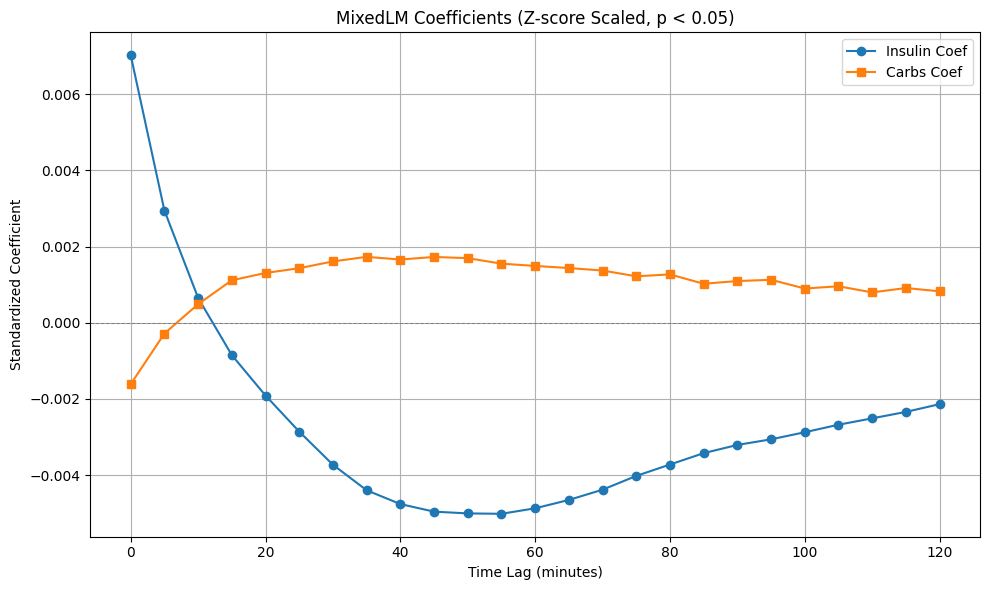

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler  # ‚úÖ Z-score Ï†ïÍ∑úÌôîÏö©

# 0. ‚úÖ ÏÇ¨Ïö©ÏûêÎ≥Ñ ÎßàÏßÄÎßâÎÇ† Ìè¨Ìï® 10ÏùºÏπò Îç∞Ïù¥ÌÑ∞Îßå Ïú†ÏßÄ
filtered_df = []

for ptid, group in df.groupby("PtID"):
    max_date = group["DeviceDtTm"].max().normalize()               # ÎßàÏßÄÎßâ ÎÇ†Ïßú
    start_date = max_date - pd.Timedelta(days=10)                  # 10Ïùº Ï†Ñ
    filtered = group[
        (group["DeviceDtTm"].dt.normalize() >= start_date) &
        (group["DeviceDtTm"].dt.normalize() <= max_date)
    ]
    filtered_df.append(filtered)

df = pd.concat(filtered_df, ignore_index=True)
# 0-1. ÌïÑÏöîÌïú Ïó¥Îßå ÏÑ†ÌÉùÌïòÍ≥† Í≤∞Ï∏° Ï≤òÎ¶¨
cols_to_use = ["CGM", "BasalRate", "BolusAmount", "CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

significant_ptids = [
    1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25,
    26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47,
    48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69,
    70, 72, 73, 74, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95,
    97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109
]


# 1. Ïú†ÏùòÌïú PtIDÎßå ÌïÑÌÑ∞ÎßÅ
df_sig = df[df["PtID"].isin(significant_ptids)].copy()


results = []

for lag in range(0, 25):  # 0~120Î∂Ñ, 5Î∂Ñ Îã®ÏúÑ
    lag_min = lag * 5
    df_lagged = df_sig.copy()

    # üëâ Lag ÏÉùÏÑ±
    for col in ["BasalRate", "BolusAmount", "CarbAmount"]:
        df_lagged[f"{col}_lag"] = df_lagged.groupby("PtID")[col].shift(lag)

    df_lagged["insulin_total_lag"] = df_lagged["BasalRate_lag"] + df_lagged["BolusAmount_lag"]
    df_lagged["insulin_x_carb_lag"] = df_lagged["insulin_total_lag"] * df_lagged["CarbAmount_lag"]
    df_lagged["bg_diff"] = df_lagged.groupby("PtID")["CGM"].diff()

    predictors = ["insulin_total_lag", "CarbAmount_lag", "insulin_x_carb_lag"]
    df_model = df_lagged[["bg_diff", "PtID"] + predictors].dropna()

    if df_model.empty:
        continue

    # ‚úÖ Z-score Ï†ïÍ∑úÌôî
    scaler = StandardScaler()
    scaled_predictors = pd.DataFrame(
        scaler.fit_transform(df_model[predictors]),
        columns=predictors,
        index=df_model.index
    )

    exog = sm.add_constant(scaled_predictors)  # Í≥†Ï†ï Ìö®Í≥º
    exog_re = scaled_predictors[["insulin_total_lag"]]  # random slope
    endog = df_model["bg_diff"]

    try:
        md = MixedLM(endog, exog, groups=df_model["PtID"], exog_re=exog_re)
        mdf = md.fit()

        results.append({
            "lag_min": lag_min,
            "N": len(df_model),
            "R_squared": np.nan,
            "model_pval": np.nan,
            "insulin_coef": mdf.params.get("insulin_total_lag"),
            "insulin_pval": mdf.pvalues.get("insulin_total_lag"),
            "carbs_coef": mdf.params.get("CarbAmount_lag"),
            "carbs_pval": mdf.pvalues.get("CarbAmount_lag"),
        })
    except Exception as e:
        print(f"[lag={lag_min}Î∂Ñ] Î™®Îç∏ Ïã§Ìå®: {e}")
        continue

# üëâ Í≤∞Í≥º Ï†ïÎ¶¨
df_results = pd.DataFrame(results)
sig_lag_df = df_results.query("insulin_pval < 0.05 or carbs_pval < 0.05").copy()

# üëâ Ï∂úÎ†•
print("üìå Ïú†ÏùòÌïú lag ÏöîÏïΩ (MixedLM):")
print(sig_lag_df[["lag_min", "insulin_coef", "insulin_pval", "carbs_coef", "carbs_pval"]].round(4).to_string(index=False))

top_insulin = sig_lag_df.loc[sig_lag_df["insulin_coef"].abs().idxmax()]
top_carbs = sig_lag_df.loc[sig_lag_df["carbs_coef"].abs().idxmax()]

print("\nüîç ÏòÅÌñ•Ïù¥ Í∞ÄÏû• ÌÅ∞ lag (MixedLM)")
print(f"  ‚ñ∂ insulin: {top_insulin['lag_min']}Î∂Ñ (coef={top_insulin['insulin_coef']:.4f}, p={top_insulin['insulin_pval']:.100f})")
print(f"  ‚ñ∂ carbs:   {top_carbs['lag_min']}Î∂Ñ (coef={top_carbs['carbs_coef']:.4f}, p={top_carbs['carbs_pval']:.100f})")

# üëâ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
plt.plot(sig_lag_df["lag_min"], sig_lag_df["insulin_coef"], marker='o', label="Insulin Coef")
plt.plot(sig_lag_df["lag_min"], sig_lag_df["carbs_coef"], marker='s', label="Carbs Coef")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("MixedLM Coefficients (Z-score Scaled, p < 0.05)")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Standardized Coefficient")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# ÎßàÏßÄÎßâÏóê fit ÏôÑÎ£åÎêú MixedLM Í≤∞Í≥º Í∞ùÏ≤¥ mdf Ïù¥Ïö©
print(mdf.summary())                     # AIC¬∑BIC¬∑LLF Îì± Ï†ÑÏ≤¥ Ìëú
ci = mdf.conf_int()                      # 95 % Ïã†Î¢∞Íµ¨Í∞Ñ
print(ci.loc[['insulin_total_lag', 'CarbAmount_lag']])


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   bg_diff    
No. Observations:     262642    Method:               REML       
No. Groups:           93        Scale:                0.0007     
Min. group size:      280       Log-Likelihood:       586941.1968
Max. group size:      3122      Converged:            Yes        
Mean group size:      2824.1                                     
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
const                 -0.000    0.000  -1.631 0.103 -0.000  0.000
insulin_total_lag     -0.002    0.000 -12.828 0.000 -0.002 -0.002
CarbAmount_lag         0.001    0.000   9.311 0.000  0.001  0.001
insulin_x_carb_lag    -0.000    0.000  -0.540 0.589 -0.000  0.000
insulin_total_lag Var  0.000    0.000                            

                       

c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

üìå Ïú†Ïùò lag (p<0.05)


c:\Users\asap0\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


lag_min  insulin_coef  insulin_pval  carbs_coef  carbs_pval
0         0        0.0073        0.0000     -0.0011      0.1644
1         5        0.0030        0.0000     -0.0001      0.6363
2        10        0.0006        0.0057      0.0005      0.0006
3        15       -0.0009        0.0000      0.0011      0.0000
4        20       -0.0020        0.0000      0.0015      0.0000
5        25       -0.0029        0.0000      0.0017      0.0000
6        30       -0.0039        0.0000      0.0017      0.0000
7        35       -0.0046        0.0000      0.0018      0.0000
8        40       -0.0049        0.0000      0.0015      0.0000
9        45       -0.0052        0.0000      0.0014      0.0000
10       50       -0.0052        0.0000      0.0014      0.0000
11       55       -0.0052        0.0000      0.0012      0.0000
12       60       -0.0051        0.0000      0.0011      0.0000
13       65       -0.0048        0.0000      0.0011      0.0000
14       70       -0.0045        0.0000      0.0011      0.0000
15       75       -0.0042        0.0000      0.0010      0.0000
16       80       -0.0039        0.0000      0.0011      0.0000
17       85       -0.0036        0.0000      0.0008      0.0000
18       90       -0.0034        0.0000      0.0009      0.0000
19       95       -0.0032        0.0000      0.0009      0.0000
20      100       -0.0030        0.0000      0.0007      0.0000
21      105       -0.0028        0.0000      0.0008      0.0000
22      110       -0.0026        0.0000      0.0006      0.0000
23      115       -0.0024        0.0000      0.0008      0.0000
24      120       -0.0022        0.0000      0.0007      0.0000


üîç ÏµúÎåÄ Ìö®Í≥º lag
  insulin : 0.0Î∂Ñ, Œ≤=0.0073, p=5.59e-22
  carbs   : 35.0Î∂Ñ, Œ≤=0.0018, p=1.53e-19


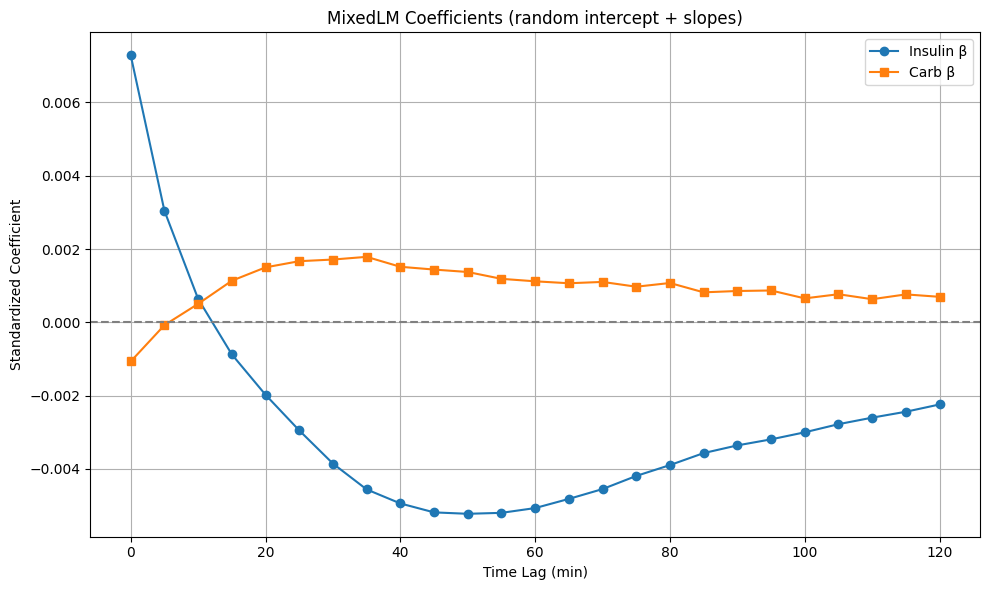

In [ ]:
# ÎûúÎç§ Ìö®Í≥º Î∞òÏòÅ



# ---------- 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ ----------------------------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler

# ---------- 2. ÏµúÍ∑º 10Ïùº Îç∞Ïù¥ÌÑ∞Îßå Ïú†ÏßÄ ---------------
filtered = []
for pid, g in df.groupby("PtID"):
    last_day  = g["DeviceDtTm"].max().normalize()
    start_day = last_day - pd.Timedelta(days=10)
    mask = (g["DeviceDtTm"].dt.normalize() >= start_day) & (g["DeviceDtTm"].dt.normalize() <= last_day)
    filtered.append(g.loc[mask])
df  = pd.concat(filtered, ignore_index=True)

# ---------- 3. Í≤∞Ï∏° 0, Ïú†ÏùòÌïú PtID ÌïÑÌÑ∞ --------------
cols_to_use = ["CGM","BasalRate","BolusAmount","CarbAmount"]
df[cols_to_use] = df[cols_to_use].fillna(0)

sig_ids = [1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,
           30,31,32,33,34,35,36,37,38,39,40,42,43,44,46,47,48,49,50,51,52,53,55,56,
           57,58,59,60,61,62,63,64,66,67,68,69,70,72,73,74,77,78,79,81,82,83,84,85,
           86,87,88,90,91,93,94,95,97,98,99,100,102,103,104,105,106,107,109]

df_sig = df[df["PtID"].isin(sig_ids)].copy()
# ---------- 4. MixedLM Ï†ÅÌï© (ÎûúÎç§ intercept + Ïä¨Î°úÌîÑ 2Í∞ú) ----------
results, md_dict = [], {}
for lag in range(25):                       # 0~120Î∂Ñ(5Î∂Ñ Í∞ÑÍ≤©)
    lag_min = lag*5
    d = df_sig.copy()
    for c in ["BasalRate","BolusAmount","CarbAmount"]:
        d[f"{c}_lag"] = d.groupby("PtID")[c].shift(lag)

    d["insulin_total_lag"] = d["BasalRate_lag"] + d["BolusAmount_lag"]
    d["insulin_x_carb_lag"] = d["insulin_total_lag"] * d["CarbAmount_lag"]
    d["bg_diff"] = d.groupby("PtID")["CGM"].diff()

    pred_cols = ["insulin_total_lag","CarbAmount_lag","insulin_x_carb_lag"]
    dm = d[["bg_diff","PtID"] + pred_cols].dropna()
    if dm.empty: 
        continue

    # Z-score (Ï†Ñ ÌôòÏûê Í≥µÌÜµ Í∏∞Ï§Ä)
    Xscaled = pd.DataFrame(StandardScaler().fit_transform(dm[pred_cols]),
                           columns=pred_cols, index=dm.index)

    # Í≥†Ï†ïÌö®Í≥º + ÎûúÎç§Ìö®Í≥º ÌñâÎ†¨
    exog    = sm.add_constant(Xscaled)
    exog_re = Xscaled[["insulin_total_lag","CarbAmount_lag"]]  # Îëê ÎûúÎç§ Ïä¨Î°úÌîÑ
    y       = dm["bg_diff"]

    try:
        # re_formula ÏóÜÏù¥ exog_reÎ°úÎßå ÏßÄÏ†ï
        md  = MixedLM(y, exog, groups=dm["PtID"], exog_re=exog_re)
        fit = md.fit(method='lbfgs', maxiter=2000)
        md_dict[lag_min] = fit

        results.append({
            "lag_min": lag_min,
            "insulin_coef": fit.params.get("insulin_total_lag"),
            "insulin_pval": fit.pvalues.get("insulin_total_lag"),
            "carbs_coef":   fit.params.get("CarbAmount_lag"),
            "carbs_pval":   fit.pvalues.get("CarbAmount_lag"),
        })
    except Exception as e:
        print(f"[{lag_min}Î∂Ñ] Ïã§Ìå®: {e}")


# ---------- 5. Í≤∞Í≥º ÏöîÏïΩ -----------------------------
res = (pd.DataFrame(results)
       .query("insulin_pval<0.05 or carbs_pval<0.05")
       .sort_values("lag_min"))
print("üìå Ïú†Ïùò lag (p<0.05)"); display(res.round(4))

# ÏµúÎåÄ Ï†àÎåìÍ∞í lag
top_ins = res.loc[res.insulin_coef.abs().idxmax()]
top_car = res.loc[res.carbs_coef.abs().idxmax()]
print(f"\nüîç ÏµúÎåÄ Ìö®Í≥º lag\n  insulin : {top_ins.lag_min}Î∂Ñ, Œ≤={top_ins.insulin_coef:.4f}, p={top_ins.insulin_pval:.3g}"
      f"\n  carbs   : {top_car.lag_min}Î∂Ñ, Œ≤={top_car.carbs_coef:.4f}, p={top_car.carbs_pval:.3g}")

# ---------- 6. ÏãúÍ∞ÅÌôî -------------------------------
plt.figure(figsize=(10,6))
plt.plot(res.lag_min, res.insulin_coef, 'o-', label='Insulin Œ≤')
plt.plot(res.lag_min, res.carbs_coef,   's-', label='Carb Œ≤')
plt.axhline(0,color='gray',ls='--'); plt.grid(True)
plt.xlabel("Time Lag (min)"); plt.ylabel("Standardized Coefficient")
plt.title("MixedLM Coefficients (random intercept + slopes)")
plt.legend(); plt.tight_layout(); plt.show()
